In [ ]:
!pip install fa2
import re
import pandas as pd
import os
import networkx as nx
import matplotlib.pyplot as plt
import io
from collections import Counter
from fa2 import ForceAtlas2
from collections import defaultdict
import nltk
import collections
import matplotlib.cm as cm
import numpy as np
from PIL import Image
import math
!pip install WordCloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
nltk.download("popular")
from nltk.corpus import stopwords
!pip install python-louvain
import community
from IPython.display import display

# Part 1: Twitter Network Analysis

 **Exercise 1:** Build the network of retweets. We will now build a network that has as nodes the Twitter handles of the members of the house, and direct edges between nodes A and B if A has retweeted content posted by B. We will build a weighted network, where the weight of an edge is equal to the number of retweets. You can build the network following the steps below (and you should be able to reuse many of the functions you wrote in previous weeks):

* Consider the 200 most recent tweets written by each member of the house (use the files here, or the ones you produced in Part 1). For each file, use a regular expression to find retweets and to extract the Twitter handle of the user whose content was retweeted. All retweets begin with "RT @originalAuthor:", where "originalAuthor" is the handle of the user whose content was retweeted (and the part of the text you want to extract).

* For each retweet, check if the handle retweeted is the one of a member of the house. If yes, keep it. If no, discard it.

In [0]:
# get string that matches regexes in given files
def extractStringsMatchingRegex(file_path , regex ):
  
    # Open file
    f = open(file_path, 'r', encoding="utf8")
    # Feed the file text into findall(); it returns a list of all the found strings
    strings = re.findall(regex, f.read())
    return strings

In [0]:
directory_path = '/content/gdrive/My Drive/data/tweets'
#regex to extract retweets
regex = 'RT \@([a-zA-Z0-9_]*)'
house_members_filepath = '/content/gdrive/My Drive/data/H115_tw.csv'



#list to store directory containing the tweets for each politician
file_paths = []

for file in os.listdir(directory_path):
    file_paths.append(os.path.join(directory_path, file))


dictionary_of_retweets = {}

for file_path in file_paths:

    retweets = []
    
    #get twitter handle of politiician who retweets
    key = file_path.rsplit('/', 1)[1]
    
    #extract handles from where the retweet is from
    regex_list = extractStringsMatchingRegex(file_path,regex)
    #add as key the politician who retweets and as values, the pages he retweets
    dictionary_of_retweets[key] = regex_list

# read file with politiicians twitter handle and party
house_members_df= pd.read_csv(house_members_filepath)


# create dictionary only with retweets of fellow politicians as values

dictionary_of_filtered_retweets = {}

for key, value in dictionary_of_retweets.items():
    
    filtered_retweets = [x for x in value if x in list(house_members_df['tw_name'])]
    dictionary_of_filtered_retweets[key] = filtered_retweets
    
# create dictionary without_loops, meaning without the retweets a page does from its own content

dictionary_of_filtered_retweets_without_loops = {}

for key, value in dictionary_of_filtered_retweets.items():
    
    count = 0
  
    for y in value:
      if y == key:
        count += 1
    filtered_retweets = []
    filtered_retweets = [x for x in value if x != key]
    dictionary_of_filtered_retweets_without_loops[key] = filtered_retweets    

* Use a NetworkX DiGraph to store the network. Use weighted edges to account for multiple retweets. Store also the party of each member as a node attribute (use the data in this file, or the data you downloaded in Part 1). Remove self-loops (edges that connect a node with itself).

In [0]:
G = nx.DiGraph()

#graph which includes nodes that have a 0 degree it will be user for a latter plot of the weighted outgoing degrees

G_with_zero_deg_nodes = nx.DiGraph() 

#all politicians get assigned a node in the graph which includes 0 degree politicians

for member in list(house_members_df['tw_name']):
    G_with_zero_deg_nodes.add_node(member)
    
    
for key , value in dictionary_of_filtered_retweets_without_loops.items():
    # get the number of retweets that a politician has made from other politician pages
    retweets_counter = Counter(value)
    
    #for each page that was retweeted and how many times 
    for key_2, value_2 in retweets_counter.items():
        #add edge between node that retweets and retweeted page with weight equalling how many retweets were made
        G.add_edge(key, key_2, weight=value_2)
        G_with_zero_deg_nodes.add_edge(key, key_2, weight=value_2)
        
       
#create dictionary of party atributes for both graphs

node_attributes = {}
node_attributes_with_zero_degree_nodes = {}

for node in G.nodes():
  
  #check what party the node corresponds to using the provided file with the twitter hanldes and party
  if house_members_df.loc[house_members_df['tw_name'] == node, 'Party'].item() == "Democratic":
    node_attributes[node] = "Democratic"
  else:
    node_attributes[node] = "Republican"
    
for node in G_with_zero_deg_nodes.nodes():
  
   #check what party the node corresponds to using the provided file with the twitter hanldes and party
  if house_members_df.loc[house_members_df['tw_name'] == node, 'Party'].item() == "Democratic":
    node_attributes_with_zero_degree_nodes[node] = "Democratic"
  else:
    node_attributes_with_zero_degree_nodes[node] = "Republican"
  
    

#store party of each node as a node attribute       
nx.set_node_attributes(G,node_attributes,name = 'party')
        
nx.set_node_attributes(G_with_zero_deg_nodes,node_attributes_with_zero_degree_nodes,name = 'party')


 **Exercise 2**: Visualize the network of retweets and investigate differences between the parties.

* Visualize the network using the Networkx draw function, and nodes coordinates from the force atlas algorithm (see Week 5, Exercise 2). Hint: use the undirected version of the graph to find the nodes positions for better results, but stick to the directed version for all measurements. Plot nodes in colors according to their party (e.g. 'red' for republicans and 'blue' for democrats) and set the nodes' size proportional to their total degree.
  * Compare the network of Retweets with the network of Wikipedia pages (Week 5, exercise 2). Do you observe any difference? How do you explain them?
  

In [0]:
#dictionary with each node as key and its party as value for graph with and without zero degree nodes

party_attributes = nx.get_node_attributes(G, 'party')
party_attributes_zero_degree_graph =  nx.get_node_attributes(G_with_zero_deg_nodes, 'party')

weights = [G[u][v]['weight'] for u,v in G.edges]

#create color map for the nodes
color_map_nodes = []

for i in party_attributes.values():
    if i == "Democratic":
        color_map_nodes.append("b")
    else:
        color_map_nodes.append("r")
        
        
#create color map for the edges
color_map_edges = []

for u,v in G.edges:
  
  #cyan for retweets between parties
  if party_attributes[u] != party_attributes[v]:
    color_map_edges.append("c")
    
  #grey for retweets between the same party
  elif party_attributes[u] == party_attributes[v] :
    color_map_edges.append("grey")



In [0]:
G_undirected = G.to_undirected()

#get positions of edges and nodes


forceatlas2 = ForceAtlas2(
                          # Behavior alternatives
                          outboundAttractionDistribution=False,  # Dissuade hubs
                          linLogMode=False,  # NOT IMPLEMENTED
                          adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                          edgeWeightInfluence=0.5,

                          # Performance
                          jitterTolerance=0.2,  # Tolerance
                          barnesHutOptimize=True,
                          barnesHutTheta=0.5,
                          multiThreaded=False,  # NOT IMPLEMENTED

                          # Tuning
                          scalingRatio=6.0,
                          strongGravityMode=False,
                          gravity=0,

                          # Log
                          verbose=False)


positions = forceatlas2.forceatlas2_networkx_layout(G_undirected, pos=None, iterations=10000)


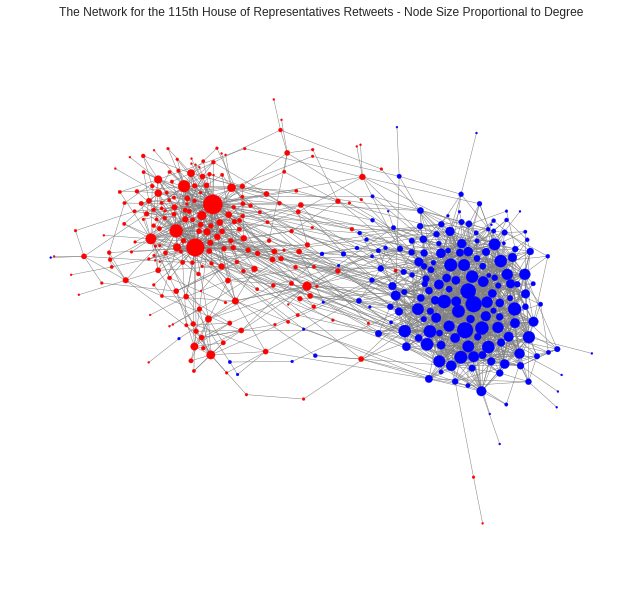

In [69]:
d = G.degree()

G_undirected = G.to_undirected()

plt.figure(1,figsize=(10,10))
nx.draw_networkx(G_undirected, pos = positions, node_color = color_map_nodes, node_size=[v[1] * 4 for v in d],edge_color = "grey" , width =0.5, with_labels=False)
plt.xlim(400,1800)
plt.ylim(-1000,400)
plt.axis('off')
plt.title('The Network for the 115th House of Representatives Retweets - Node Size Proportional to Degree')
plt.show()

**Figure 1** - The Network for the 115th House of Representatives Retweets - Node Size Proportional to Degree





The difference  between the wikipedia network and the retweets network is quite evident in Figure 1. In the wikipedia network, members from both parties sort of mixed together in one big agglomeration without a clear visual separation as in  the retweet network it is evident that most politicians have the majority of their retweets from members of their own party just by looking at the visualization of the network. 
This is explained by the difference in the nature of the two platforms (wikipedia vs twitter) as one is purely informative/impartial and its content is not directly managed by any of the politiicians when in twitter it is the other way around. Given the rivalry between parties it makes sense that a democrat does not often use his platform to draw attention to the Republicans and vice versa, except maybe for some instances of cross party collaborations or to share causes that they both support.

It is also worth noting that the network visualized **lacks the politcians with zero degree**, there are 36 politicians that have neither retweeted any fellow politicinas or gotten retweets from them. For simplicity of the visualization they have not been included, we plotted the network that does not include this individuals (G). Considering the network's node size is proportional to the degree of each node, they would have not appeared anyway.

In [93]:
fraction_cross_party_retweets = len([(u,v) for u,v in G.edges if party_attributes[u] != party_attributes[v]])/len(G.edges()) 
print(fraction_cross_party_retweets)

0.06318082788671024


To support what was stated about Figure 1, the cell above shows that the **percentage concerning  cross party edges is indeed only 6,3 %** of the total number of edges.

* Now set the nodes' size proportional to their betweenness centrality. What do you observe?


In [11]:
components = nx.weakly_connected_components(G)
components = list(components)
print("length of G's GCC:",len(components[0]))
print("length of G's other component:",len(components[1]))


length of G's GCC: 382
length of G's other component: 2


**All the following centrality measures will be performed on the G network**. As stated before, **this network does not include any politiicians with a total degree of 0 as these 36 politicians would affect the results** and we wish to focus on metrics concerning the politicians who are actually engaging in this network . When running nx.weakly_connected_components(G) networkx still indicates G is not "fully connected" but rather made out of 2 connected components, however one of them is merely composed of 2 politicians as the above cell shows so we did not find it necessary to run this centrality measures on the G's "GCC" as results would differ very little.


  Number of nodes with betweenness centrality equal to 0:  134 




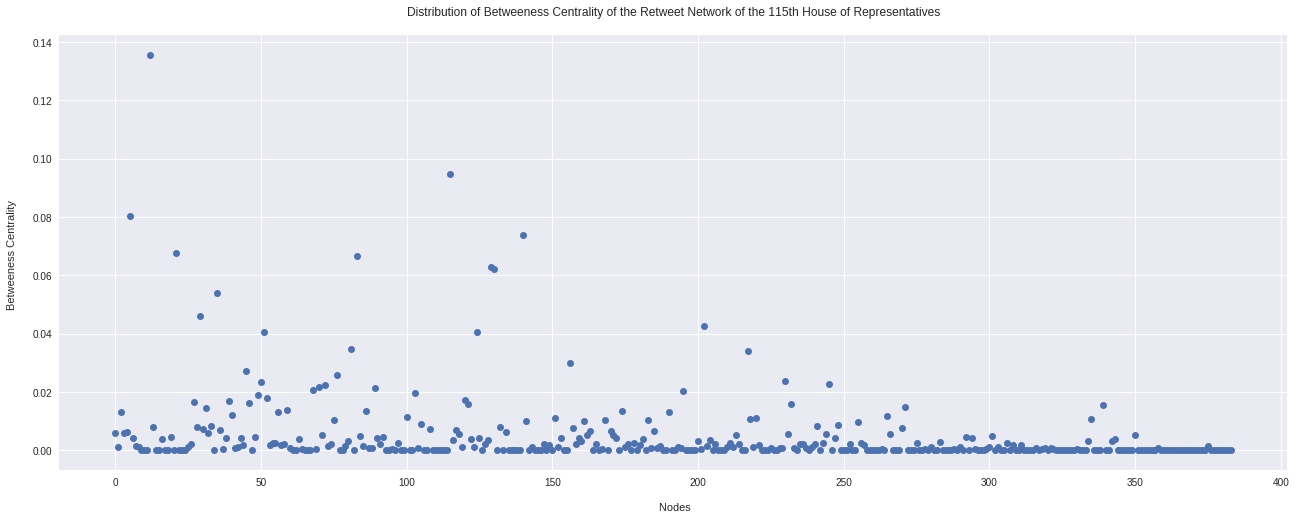

In [12]:
#plot betweenness centrality of network for visual reference

betweenness_centrality = nx.betweenness_centrality(G)


print("\n  Number of nodes with betweenness centrality equal to 0: ",list(betweenness_centrality.values()).count(0.0),"\n\n")

plt.figure(figsize = (22,8))
plt.plot(list(betweenness_centrality.values()),'o') 
plt.title("Distribution of Betweeness Centrality of the Retweet Network of the 115th House of Representatives\n")
plt.xlabel("\n Nodes")
plt.ylabel("Betweeness Centrality \n")
plt.show()

**Figure 2**  - Distribution of Betweeness Centrality of the Retweet Network of the 115th House of Representatives. 



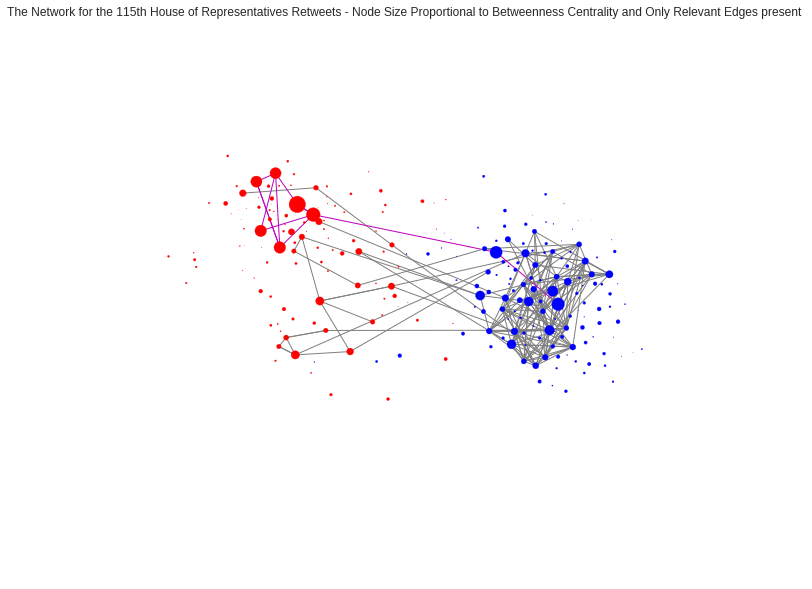

In [70]:
#create edges that connect relevant nodes concercing betweenness centrality
relevant_edges = []
color_map_edges_betweenness = []

for u,v in G.edges:
  
  if  0.05 > betweenness_centrality[u] >= 0.01 and 0.05 > betweenness_centrality[v] >= 0.01:
    
    relevant_edges.append((u,v))
    #grey color for edges that connect nodes with a betweenness centrality between 0.01 and 0.05
    color_map_edges_betweenness.append("grey")
    
  elif betweenness_centrality[u] >= 0.05 and betweenness_centrality[v] >= 0.05:
    
    relevant_edges.append((u,v))
    #mangenta color for edges that connect nodes with a betweenness centrality between 0.01 and 0.05
    color_map_edges_betweenness.append("m")
      
    
    

plt.figure(1,figsize=(10,10))

nx.draw_networkx_nodes(G_undirected, positions, node_color = color_map_nodes,
                       node_size=[v* 2000 for v in betweenness_centrality.values()], with_labels=True)
nx.draw_networkx_edges(G_undirected,positions,edgelist = relevant_edges,
                       edge_color = color_map_edges_betweenness, width = 1)
plt.xlim(400,1800)
plt.ylim(-1000,400)
plt.axis('off')

plt.title('The Network for the 115th House of Representatives Retweets - Node Size Proportional to Betweenness Centrality and Only Relevant Edges present ')
plt.show()


plt.show()

**Figure 3** -  The Network for the 115th House of Representatives Retweets - Node Size Proportional to Betweenness Centrality. The mangenta edges represent connections between nodes with  a considerable value of betweeness centrality (greater than 0.05) in the scope of the network and therefore indicate the nodes with the biggest importance in the flow of communication within the network. Grey edges represent connections between nodes with betweeness centralities in the [0.01,0.05[ range. **All edges connecting nodes with betweenness centrality lower than 0.01 were removed.**



In Figure 3 we  observe that many of the nodes disappear and a great number of those who "stay" reveal very low values of betweenness centrality. This is due to te fact that 134 nodes have a betweenness centralty of 0  as stated at the top of Figure 2.  We also observe that there are but a few "big players" in connecting the community of "Republicans" and the community of "Democrats",  6 republicans and 2 democrats to be exact.

* Repeat the point above using eigenvector centrality instead. Is there any difference? Can you explain why?


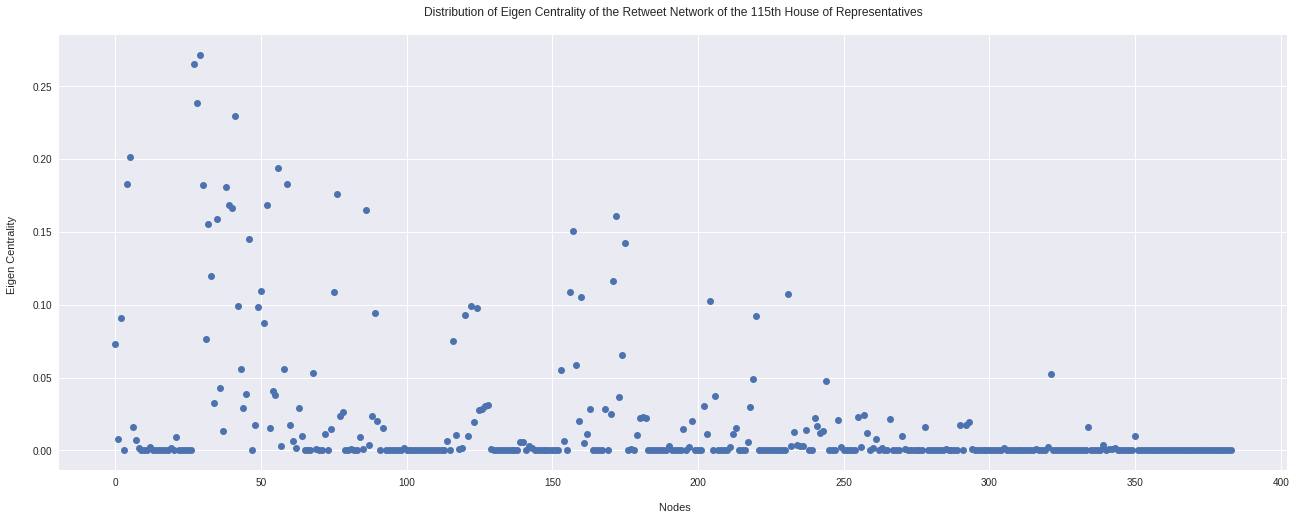

In [14]:
#plot eigen centrality of network for visual reference


eigen_centrality = nx.eigenvector_centrality(G)

plt.figure(figsize = (22,8))
plt.plot(list(eigen_centrality.values()),'o') 
plt.title("Distribution of Eigen Centrality of the Retweet Network of the 115th House of Representatives\n")
plt.xlabel("\n Nodes")
plt.ylabel("Eigen Centrality \n")
plt.show()



**Figure 4** - Distribution of Betweeness Centrality of the Retweet Network of the 115th House of Representatives


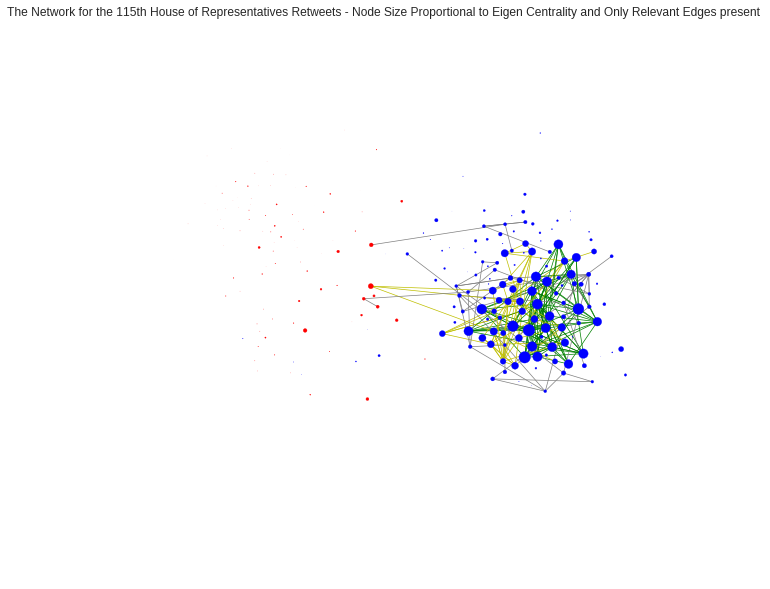

In [71]:
#create edges that connect relevant nodes concercing eigen centrality
relevant_edges_eigen = []
color_map_edges_eigen = []

for u,v in G.edges:
  
  if  0.05 > eigen_centrality[u] >= 0.015  and 0.05 > eigen_centrality[v] >= 0.015:
    
    relevant_edges_eigen.append((u,v))
    #grey color for edges that connect nodes with an eigen centrality between 0.015 and 0.05
    color_map_edges_eigen.append("grey")
    
  elif 0.14 > eigen_centrality[u] >= 0.05 and 0.14 > eigen_centrality[v] >= 0.05:
    
    relevant_edges_eigen.append((u,v))
    #yellow color for edges that connect nodes with an eigen centrality between 0.05 and 0.14
    color_map_edges_eigen.append("y")
  
  elif eigen_centrality[u] >= 0.14 and eigen_centrality[v] >= 0.14:
    
    relevant_edges_eigen.append((u,v))
    #green color for edges that connect nodes with an eigen centrality greater than 0.14
    color_map_edges_eigen.append("g")

    
    

plt.figure(1,figsize=(10,10))

nx.draw_networkx_nodes(G_undirected, positions, node_color = color_map_nodes,node_size=[v* 500 for v in eigen_centrality.values()], with_labels=False)
nx.draw_networkx_edges(G_undirected,positions,edgelist = relevant_edges_eigen,edge_color = color_map_edges_eigen, width = 0.7, arrows = True)

plt.xlim(400,1800)
plt.ylim(-1000,400)
plt.axis('off')

plt.title('The Network for the 115th House of Representatives Retweets - Node Size Proportional to Eigen Centrality and Only Relevant Edges present ')
plt.show()


plt.show()



**Figure 5** -  The Network for the 115th House of Representatives Retweets - Node Size Proportional to Eigen Centrality. The green edges represent connections between nodes with  a considerable value of eigen centrality (greater than 0.14) in the scope of the network and therefore indicate the nodes with the biggest importance in the flow of communication within the network. Yellow edges represent connections between nodes with betweeness centralities in the [0.05,0.14[ range.  Grey edges represent connections between nodes with betweeness centralities in the [0.015,0.05[ range. **All edges connecting nodes with betweenness centrality lower than 0.015 were removed.**


**Answer:** As seen in *Figure 5*, eigen centrality seems to rest mostly in the Democratic side. All the links between the biggest players of the network concercing eigen centrality also occur between democrats. A reason for this may be the fact that, as we will have the chance to see ahead, democrats in general have a greater out degree than republicans meaning they retweet more. This consideration alligned with the fact a politician tends t mostlyy retweet colleagues from his own party,  makes the democrats "control" of the eigen centrality metric seem reasonable.

* Who are the three nodes with highest degree within each party? And eigenvector centrality? And betweenness centrality?

In [0]:
#create dataframes which will be used to display the results 
fill_dataframe = np.zeros(shape=(3,3))

top_democrats = pd.DataFrame(fill_dataframe,columns = ["TOP3_Dem_degree","TOP3_Dem_betweenness","TOP3_Dem_eigen"])
top_republicans = pd.DataFrame(fill_dataframe,columns = ["TOP3_Rep_degree","TOP3_Rep_betweenness","TOP3_Rep_eigen"])


In [20]:
# create centrality dictionary for democrats and republicans separately

d = dict(d)

degree_democrats = {}
degree_republicans = {}

for politician in d.keys():
  
  if party_attributes[politician] == "Democratic":
    
    # key is a democrat and the value is his degree in the network
    degree_democrats[politician] = d[politician]
  
  else:
    
    # key is a republican and the value is his degree in the network
    degree_republicans[politician] = d[politician]

# Get the top 3 politicians

top_democrats_degree= sorted(degree_democrats.items(), key=lambda kv: kv[1],reverse=True)[0:3]
top_republicans_degree= sorted(degree_republicans.items(), key=lambda kv: kv[1],reverse=True)[0:3]

#add top politicians to dataframe
top_democrats["TOP3_Dem_degree"]= top_democrats_degree
top_republicans["TOP3_Rep_degree"]= top_republicans_degree


#REPEAT THE SAME PROCESS for the betweenness centrality measure

#create betweenness vector centrality dictionary for democrats and republicans separately


betweenness_democrats = {}
betweenness_republicans = {}

for politician in betweenness_centrality.keys():
  
  if party_attributes[politician] == "Democratic":
    
    betweenness_democrats[politician] = betweenness_centrality[politician]
  
  else:
    
    betweenness_republicans[politician] = betweenness_centrality[politician]
    
#get the top 3 politicians
top_democrats_betweenness= sorted(betweenness_democrats.items(), key=lambda kv: kv[1],reverse=True)[0:3]
top_republicans_betweeness= sorted(betweenness_republicans.items(), key=lambda kv: kv[1],reverse=True)[0:3]

#add top politicians to dataframe
top_democrats["TOP3_Dem_betweenness"] = top_democrats_betweenness
top_republicans["TOP3_Rep_betweenness"]= top_republicans_betweeness


#REPEAT one last time for eigen centrality

#create eigen vector centrality dictionary for democrats and republicans separately


eigen_democrats = {}
eigen_republicans = {}

for politician in eigen_centrality.keys():
  
  if party_attributes[politician] == "Democratic":
    
    eigen_democrats[politician] = eigen_centrality[politician]
  
  else:
    
    eigen_republicans[politician] = eigen_centrality[politician]

    
top_democrats_eigen= sorted(eigen_democrats.items(), key=lambda kv: kv[1],reverse=True)[0:3]
top_republicans_eigen= sorted(eigen_republicans.items(), key=lambda kv: kv[1],reverse=True)[0:3]

top_democrats["TOP3_Dem_eigen"]= top_democrats_eigen
top_republicans["TOP3_Rep_eigen"]= top_republicans_eigen


#display dataframes
display(top_democrats)
print("\n")
display(top_republicans)


,TOP3_Dem_degree,TOP3_Dem_betweenness,TOP3_Dem_eigen
0,"(NancyPelosi, 63)","(NancyPelosi, 0.0804852442575464)","(repmarkpocan, 0.2711253240032713)"
1,"(repmarkpocan, 63)","(RepDavidEPrice, 0.07385932654396467)","(RepBeatty, 0.26512142006576583)"
2,"(WhipHoyer, 58)","(WhipHoyer, 0.05388110799528388)","(RepCummings, 0.2379947061110729)"


,TOP3_Rep_degree,TOP3_Rep_betweenness,TOP3_Rep_eigen
0,"(SpeakerRyan, 93)","(SpeakerRyan, 0.13554988307097635)","(RosLehtinen, 0.05314724954872864)"
1,"(SteveScalise, 79)","(PatrickMcHenry, 0.0949014377977761)","(RepSteveStivers, 0.029545350089313402)"
2,"(GOPLeader, 42)","(SteveScalise, 0.06778964104682705)","(justinamash, 0.02840368203700182)"


**Table 1 and Table 2** - Top 3 politicians for each party  and the corresponding value for the centrality measure used (degree centrality, betweenness centrality and eigen centrality)

* Plot on the same figure the distribution of outgoing strength for the republican and democratic nodes (e.g. the sum of the weight on outgoing links). Which party is more active in retweeting other members of the house?


In [0]:
#dictionary with all the outgoing degrees for each politician accouting for the weight 
dictionary_out_degrees = dict(G_with_zero_deg_nodes.out_degree(weight = 'weight'))

#get all outgoing degrees (accounting for weight) in separate lists according to party


out_degrees_democrats = []
out_degrees_republicans = []


for politician in dictionary_out_degrees.keys():
  
  if party_attributes_zero_degree_graph[politician] == "Democratic":
    out_degrees_democrats.append(dictionary_out_degrees[politician])
    
  else:
    out_degrees_republicans.append(dictionary_out_degrees[politician])
    
democrats_count_out = []
republicans_count_out = []

#create bins / x values for plotting democrats
democrats_bins = sorted(list(set(out_degrees_democrats)))
#create bins / y values for plotting the republicans
republicans_bins = sorted(list(set(out_degrees_republicans)))

#get the count corresponding to each outgoing degree for the democrats
for i in sorted((list(set(out_degrees_democrats)))):
    democrats_count_out.append(out_degrees_democrats.count(i))

#get the count corresponding to each outgoing degree for the republicans

for i in sorted((list(set(out_degrees_republicans)))):
    republicans_count_out.append(out_degrees_republicans.count(i))

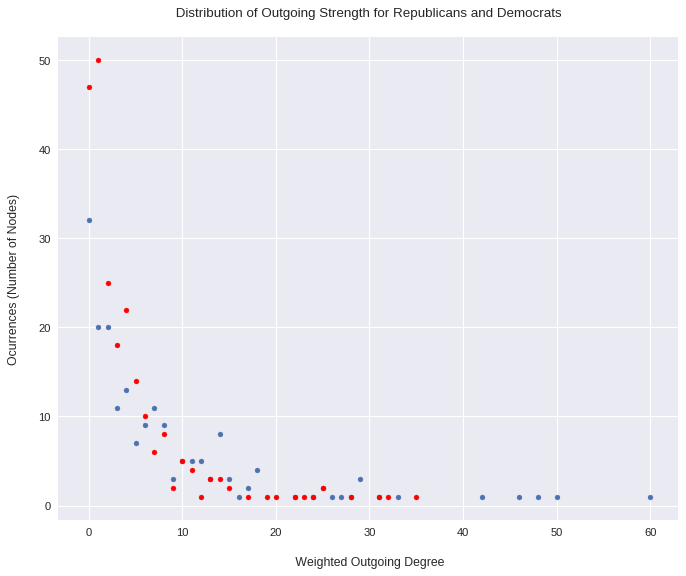

In [22]:
fig=plt.figure(figsize=(10, 8), dpi= 80, facecolor='w', edgecolor='w')

plt.scatter(democrats_bins,democrats_count_out, s = 20)
plt.scatter(republicans_bins,republicans_count_out, c = 'r', s = 20)
plt.xlabel("\n Weighted Outgoing Degree")
plt.ylabel("Ocurrences (Number of Nodes)\n")
plt.title (" Distribution of Outgoing Strength for Republicans and Democrats \n")
plt.show()

**Figure 6** - Distribution of Outgoing Strength for Republicans and Democrats

**Answer:** As shown in figure 6,  both parties differ mostly at the lowest and largest values of Weighted Outgoing Degree. The republicans have around 15 more members which do not retweet  anything as well as more members than the democrats who retweeted from 1 to 6 times.  As the value of the weighted outgoing degree increases, the parties sort of mix together and then, for values greater than 40 retweets, only democrats are present with 5 members showing to be extremely active when retweeting fellow politicians.

**For this figure the Network which includes zero degree nodes was used** as to properly display how many people are actually innactive when it comes to retweeting. It simply increases the number of nodes with a 0 weighted outgoing degree .





In [23]:
print("Sum of weighted outgoing degrees (retweets made) for republicans:",sum(out_degrees_republicans))
print("Sum of weighted outgoing degrees (retweets made) for democrats:",sum(out_degrees_democrats))
print("The democrats are %s %s more active than republicans when retweeting fellow politiicians" %(100*sum(out_degrees_democrats)/sum(out_degrees_republicans) - 100,"%"))

Sum of weighted outgoing degrees (retweets made) for republicans: 1014
Sum of weighted outgoing degrees (retweets made) for democrats: 1467
The democrats are 44.67455621301775 % more active than republicans when retweeting fellow politiicians


* Find the 3 members of the republican party that have retweet more often tweets from democratic members. Repeat the measure for the democratic members. Can you explain your results by looking at the Wikipedia pages of these members of the house? 


In [25]:
#create list with pairs of the kind (politician,weight of tweet to other party)

#cross_party_weights = [(u,G[u][v]['weight']) for u,v in G.edges if party_attributes[u] != party_attributes[v]] 
cross_party_weights_republicans_to_democrats = [(u,G[u][v]['weight']) for u,v in G.edges if party_attributes[u] == "Republican" and party_attributes[v] == "Democratic"]
cross_party_weights_democrats_to_republicans = [(u,G[u][v]['weight']) for u,v in G.edges if party_attributes[u] == "Democratic" and party_attributes[v] == "Republican"]

# join the values from the list in a dictionary with the format { politician : 1,2,3 } where the values are the weights of each retweet that politician has made from pages of opposing parties
dict_cross_party_weights_republicans_to_democrats = defaultdict(list)
dict_cross_party_weights_democrats_to_republicans = defaultdict(list)

for k, v in cross_party_weights_republicans_to_democrats:
  
  dict_cross_party_weights_republicans_to_democrats[k].append(v)
  
for k, v in cross_party_weights_democrats_to_republicans:
  
  dict_cross_party_weights_democrats_to_republicans[k].append(v)
  
# sum the weights of each politician, i.e sum the values for each key in order to get the total retweets

for politician in dict_cross_party_weights_republicans_to_democrats.keys():
  dict_cross_party_weights_republicans_to_democrats[politician] = sum(dict_cross_party_weights_republicans_to_democrats[politician])
  
for politician in dict_cross_party_weights_democrats_to_republicans.keys():
  dict_cross_party_weights_democrats_to_republicans[politician] = sum(dict_cross_party_weights_democrats_to_republicans[politician])
  
top_democrats_that_rewteet_republicans= sorted(dict_cross_party_weights_democrats_to_republicans.items(), key=lambda kv: kv[1],reverse=True)[0:3]
top_republicans_that_retweet_democrats= sorted(dict_cross_party_weights_republicans_to_democrats.items(), key=lambda kv: kv[1],reverse=True)[0:3]

print(" TOP 3 DEMOCRATS ACCORDING TO NUMBER OF RETWEETS MADE FROM REPUBLICAN PAGES \n\n", top_democrats_that_rewteet_republicans)
print("\n--------------------------------------------------------------------------------")
print(" \n TOP 3 REPUBLICANS ACCORDING TO NUMBER OF RETWEETS MADE FROM DEMOCRATIC PAGES \n\n", top_republicans_that_retweet_democrats,"\n")

 TOP 3 DEMOCRATS ACCORDING TO NUMBER OF RETWEETS MADE FROM REPUBLICAN PAGES 

 [('RepDebDingell', 3), ('RepAnnaEshoo', 3), ('RepBeatty', 2)]

--------------------------------------------------------------------------------
 
 TOP 3 REPUBLICANS ACCORDING TO NUMBER OF RETWEETS MADE FROM DEMOCRATIC PAGES 

 [('CongressmanGT', 5), ('RepRyanCostello', 5), ('RepMikeTurner', 5)] 



**Answer:** Upon inspecting each wikipedia page, we have found no apparent reason why this specific politicians are at the top of their parties regarding retweeting content from fellow politicians from the opposing party. The only slight hint of a reason we found was for Debbie Dingell (RepDebDingell) since she used to be a republican until she married her husband (who is a democrat). 
After looking through each individual retweet for each of these politicians, the reasons for retweeting content from pages from opposites parties was virtually always due to some sort of cross-party collaboration those specific individuals (the tweeter and the retweeter) worked on (such as a law) or because of some mutual cause/event they both support.




**Exercise 3: Community detection**

- Use your favorite method of community detection to find communities in the full house of representatives network. Report the value of modularity found by the algorithm. Is it higher or lower than what you found for the Wikipedia network? Comment on your result.

In [26]:
#compute the best partition
partition = community.best_partition(G_undirected)
modularity = community.modularity(partition,G_undirected)
print(modularity)

0.4689948392937982


**Answer:** The modularity is slightly lower than what we've found on week 7's exercises for the wikipedia network (0.48 vs 4689)
This result is not surprising as , despite the different nature in the netwoks, the Louvain algorithm is still returning the modularity value of an optimal partition despite the type of communities if defines or how many it does. 
We were actually expecting for the modularity to be bigger in the twitter network, since visually  it looked a lot easier to split into differerent communities and therefore we expected its optimal partition to have a higher value of modularity. Maybe what we were actually thinking of is how many communities there would be (8 in the twitter networks vs 16 in the wikipedia one) and indeed twitter was partitioned into fewer communities. However, modularity is an overall measure of how good the partition is(which turns out to be similar for both networks) and not for how easy it is to split the network into communities or into how many communitites it gets split.

* Visualize the network, using the Force Atlas algorithm (see Lecture 5, exercise 2). This time assign each node a different color based on their community. Describe the structure you observe.

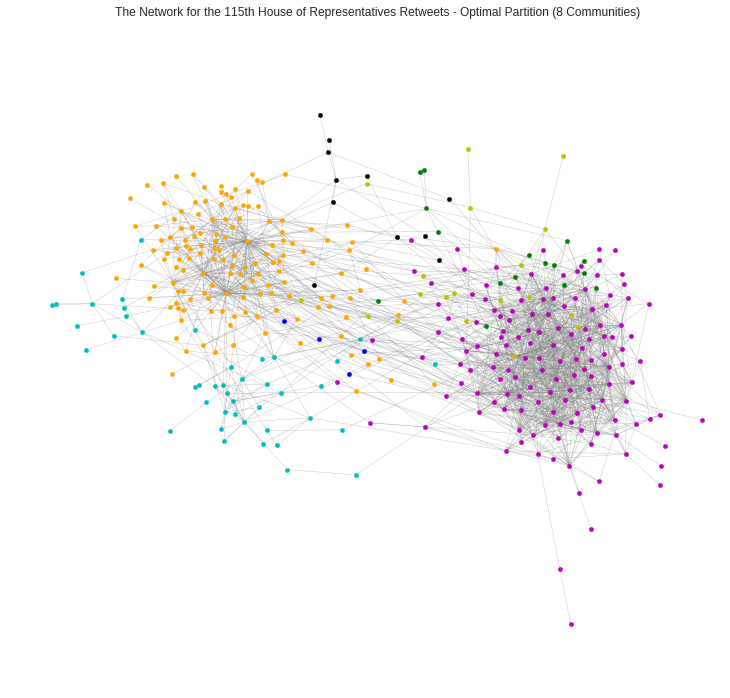

In [82]:
#number of communities
size = float(len(set(partition.values())))
count = 0.
color_each_community = ['m','b','orange','c','y','g','k','r']
plt.figure(1,figsize=(12,12))

for com in set(partition.values()) :
    count = count + 1.
    list_nodes = [nodes for nodes in partition.keys()
                                if partition[nodes] == com]
    #draw nodes for each community with a specific colour
    nx.draw_networkx_nodes(G_undirected, positions, list_nodes, node_size = 20,
                                node_color = color_each_community[int(count) -1])

#draw edges
nx.draw_networkx_edges(G_undirected, positions,edge_color = 'grey', alpha = 0.5, width = 0.4)
plt.xlim(400,1800)
plt.ylim(-1000,400)
plt.axis('off')

plt.title('The Network for the 115th House of Representatives Retweets - Optimal Partition (8 Communities)')
plt.show()

**Figure 7**- The Network for the 115th House of Representatives Retweets - Optimal Partition into Communities According to the Louvain Method


**Answer:** In Figure 7 we observe 2  main communities (represented in orange and purple) which coexist with 6 others who visually are scattered around this two. One of smaller communities (represented in light blue) seem to be a sort of extension of the orange community. The rest of the communities have small relative sizes and visually seem to perform the role of connecting the communities with the bigger size .

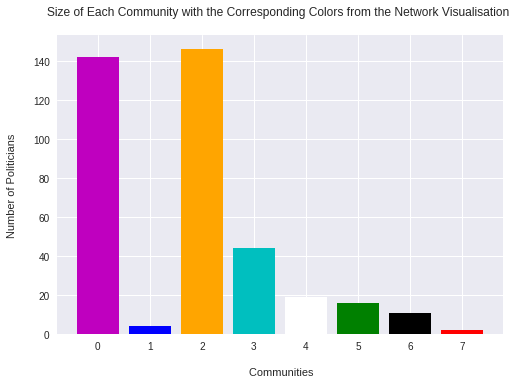

In [75]:
communites_size = {}
for com in range (8):
  communites_size[com] = list(partition.values()).count(com)

plt.bar(communites_size.keys(),communites_size.values(),color = color_each_community)

plt.xlabel("\n Communities")
plt.ylabel("Number of Politicians\n")
plt.title("Size of Each Community with the Corresponding Colors from the Network Visualisation \n")
plt.show()

#split bars in republicans / democrats?

**Figure 8**- Distribution of the Size of Each Community


 * Compare the communities found by your algorithm with the parties by creating a matrix $\mathbf{D}$ with dimension $(B \times C$, where $B$ is the number of parties and $C$ is the number of communities. We set entry $D(i,j)$ to be the number of nodes that party $i$ has in common with community $j$. The matrix $\mathbf{D}$ is what we call a confusion matrix. 

* Plot the confusion matrix and explain how well the communities you've detected correspond to the parties. Consider the following questions:

   *  Are there any republicans grouped with democrats (and vice versa)?
   * Does the community detection algorithm sub-divide the parties? Do you know anything about American politics that could explain such sub-divisions? Answer in your own words.



Matrix: 

 [[135   0   5   6  14  13   1   1]
 [  7   4 141  38   5   3  10   1]] 




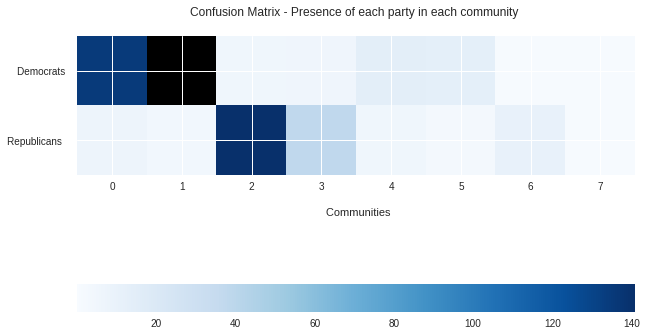

In [31]:
#create the rows for the matrix and populate them with zeros
row_democrats = np.zeros((8,), dtype=int) 
row_republicans = np.zeros((8,), dtype=int)
          
for politician,com in partition.items():
  
  #update the elements of each row with the number of members from the party in each community
  if party_attributes[politician] == "Democratic":
    row_democrats[com] +=1
  else:
    row_republicans[com] += 1
    
#create matrix
matrix = np.matrix([row_democrats,row_republicans])

print( "Matrix: \n\n",matrix,"\n\n")

#plot the matrix

fig, ax = plt.subplots(figsize=(10,10))

#used to indicate in black if a cell of the matrix is 0

cmap = plt.cm.Blues
cmap.set_under(color='black')

im = ax.imshow(matrix, interpolation = 'nearest',  cmap = cmap, vmin = 0.001)

#plt.yaxis("yeah")

plt.xlabel("\n Communities")
plt.yticks(np.arange(2), ('Democrats  ','Republicans   '))
plt.title("Confusion Matrix - Presence of each party in each community \n")

#put the colorbar horizontally below the matrix as to have a nicer plot
fig.colorbar(im, orientation="horizontal", pad=0.2)
plt.show()

**Figure 9**- Confusion Matrix regarding the distribution of both parties in each community. **The black cell indicates a value of zero**


**Answer:** 
* As we can observe, out of all communities, only community 1 does not include members from both parties (the black cell indicates a 0 value).  It is made out of 4 republicans who are displayed in a central manner in Figure 7 in blue.
* Communities 0 and 2 are by far the ones who come closer to representing a single party as they both have an overwhelming majority of politicians from one party (135 democrats in community 0 and 141 republicans in community 2)  and only a residual number of elements from the other party present (7 republicans in community 0 and 5 democrats in community 2). 
* As for the remaining  other communities,  they are quite small proportionally to the total size of the network. Except for Community 3 (44 elements) they all have 20 below elements.
* **The community detection algorithm  sub-divides the parties**, it however does not completely shift the paradigm or goes  against the traditional democrats vs republicans structure. Things such as bi-party collaboration, support of common causes, events in different locations, legislation that concerns different politicians, home state and so on  can be at the core of the formattion of this communities and therefore generate the communities we oberse in Figure7.

# Part 2: What do republican and democratic members tweet about?#

Exercise 4: TF-IDF of the republican and democratic tweets.

We will create two documents, one containing the words extracted from tweets of republican members, and the other for Democratic members. We will then use TF-IDF to compare the content of these two documents and create a word-cloud. The procedure you should use is exactly the same you used in exercise 2 of week 7. The main steps are summarized below:
- Create two large documents, one for the democratic and one for the republican party. Tokenize the pages, and combine the tokens into one long list including all the pages of the members of the same party.

In [0]:
# utility function to display two tables side by side
from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+= df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)
    
# utility class to display text in bold and underline 
class color:
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

* Exclude all twitter handles.
* Exclude punctuation.

In [0]:
# function getTweetTokens takes a path of a file and returns list of tweet tokens

def getTweetTokens(file):
  # regular expression below divides text containing tweets line by line (tweet by tweet)
  exp='(.*)\n?'
  raw_tweets = re.findall(exp,file)
  # raw tweets may contain tweet link that always starts with 'http' 
  # we use it as a seperator and we take just the first part
  raw_tweets = [tweet.split('http')[0] for tweet in raw_tweets]
  # get all word tokens from the raw text without punctuation
  tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
  tokens = []
  # create list of all tokens form a file
  for raw_tweet in raw_tweets:
    tokens +=tokenizer.tokenize(raw_tweet)
  return tokens


In [0]:
# Create empty lists of tokens for each party
republicans_list_of_tokens = []
democrats_list_of_tokens = []


for file_path in file_paths:
  # extract name of a file which is also twitter user name by 
  # splitting the filepath at the last '/' sign and then we take the second part of that split.
  user_tw_name = file_path.rsplit('/', 1)[1]
  # open file with tweets for one politician
  f = io.open(file_path,'r',encoding='utf-8').read()
  # determine if user is Republican or Democrat
  if party_attributes_zero_degree_graph[user_tw_name] == "Republican":
    republicans_list_of_tokens += getTweetTokens(f)
  else:
    democrats_list_of_tokens += getTweetTokens(f)    
   

- Exclude stop words

In [0]:
# get english stop words from nltk library
stop_words = set(stopwords.words('english')) 
# Republican tokens without stopwords
rep_no_SW = [w for w in republicans_list_of_tokens if w.lower() not in stop_words]
# Democrats tokens without stopwords
dem_no_SW = [w for w in democrats_list_of_tokens if w.lower() not in stop_words]




- In addtion we delete html tag: ''&amp' and retweet abrevation 'rt' as these words  are added automatically and  just distort the  word cloud image

In [0]:
rep_no_SW = [w for w in rep_no_SW if w !='amp' and w.lower() !='rt']
dem_no_SW = [w for w in dem_no_SW if w !='amp' and w.lower() !='rt']

- Exclude numbers (since they're difficult to interpret in the word cloud).


In [0]:
rep_no_SW_No = [w for w in rep_no_SW if not w.isdigit()]
dem_no_SW_No = [w for w in dem_no_SW if not w.isdigit()]

- Set everything to lower case



In [64]:
rep_no_SW_No_lower = [w.lower() for w in rep_no_SW_No]
dem_no_SW_No_lower = [w.lower() for w in dem_no_SW_No]

print(color.BOLD + 'Final number of tokens extracted from Democrats\' tweets: %d and Republicans\' tweets: %d'  % (len(dem_no_SW_No_lower) ,len(rep_no_SW_No_lower) ) + color.END)


Final number of tokens extracted from Democrats' tweets: 397995 and Republicans' tweets: 479382




* Compute the TF-IDF for each document.

In [0]:
# following function takes two lists of tokens and returns two dataframes of TF-IDF containing results
def calculateTFIDF(rep_tokens, dem_tokens):
  
  republican_TF_IDF = []
  democratic_TF_IDF = []
  # we operate on two big docuemnts - one for Republicans and other for Democrats
  number_of_doc = 2
  # pre-calculation length of documents
  rep_tok_tot_length = len(rep_tokens)
  dem_tok_tot_length = len(dem_tokens)
  # pre-calculation frequency distribution for two list of tokens
  rep_freq_dist = nltk.FreqDist(rep_tokens)
  dem_freq_dist = nltk.FreqDist(dem_tokens)
  # calculation of the TF-IDF for each distinct word in Republican token list
  for word,no_of_occurences in rep_freq_dist.items():
    if(dem_freq_dist[word] > 0):
      no_of_doc_it_appears_in = 2
    else:
      no_of_doc_it_appears_in = 1
    republican_TF_IDF.append((word,no_of_occurences, tfidf(no_of_occurences, rep_tok_tot_length, number_of_doc, no_of_doc_it_appears_in)))
  rep_df = pd.DataFrame(data=republican_TF_IDF,columns=['word','occurences','TF-IDF'])
  # calculation of the TF-IDF for each distinct word in Democrat token list
  for word,no_of_occurences in dem_freq_dist.items():
    if(rep_freq_dist[word] > 0):
      no_of_doc_it_appears_in = 2
    else:
      no_of_doc_it_appears_in = 1
    democratic_TF_IDF.append((word,no_of_occurences, tfidf(no_of_occurences, dem_tok_tot_length, number_of_doc, no_of_doc_it_appears_in)))
  dem_df = pd.DataFrame(data=democratic_TF_IDF,columns=['word','occurences','TF-IDF'])
  
  return (rep_df, dem_df )

In [0]:
# function tf takes document length and number of word occurences in the file and returns calculated term frequency
def tf(occurence, length):
    return occurence / length
# function idf takes number of all proccessed documents ( in our case N = 2 ) and number of documents this word appeard at least once (in our case it can be 1 or 2)
def idf(total_num_of_doc, no_of_doc_it_appeard_in):
    return math.log(total_num_of_doc / no_of_doc_it_appeard_in )
# function tfidf takes document length and number of word occurences and calculate tf-idf factor 
def tfidf(no_of_occurences,total_length, total_num_of_doc, no_of_doc_it_appeard_in ):
    return tf(no_of_occurences,total_length) * idf(total_num_of_doc,no_of_doc_it_appeard_in)

In [97]:
# control check for few most common words
fdist_Rep = nltk.FreqDist(rep_no_SW_No_lower)
print('Republicans 5 most common words:',fdist_Rep.most_common(5))
fdist_Dem = nltk.FreqDist(dem_no_SW_No_lower)
print('Democrats 5 most common words:',fdist_Dem.most_common(5))

(Rep_df,Dem_df) = calculateTFIDF(rep_no_SW_No_lower,dem_no_SW_No_lower)



Republicans 5 most common words: [('today', 5107), ('great', 3477), ('house', 2422), ('thank', 2391), ('bill', 1884)]
Democrats 5 most common words: [('today', 3499), ('trump', 2725), ('thank', 1528), ('president', 1452), ('great', 1436)]


In [62]:
print(color.BOLD + '                Republicans                                      Democrats'+ color.END)
display_side_by_side(Rep_df.sort_values(by=['TF-IDF'],ascending=False).head(10),Dem_df.sort_values(by=['TF-IDF'],ascending=False).head(10))

                Republicans                                      Democrats


,word,occurences,TF-IDF
1482,taxcutsandjobsact,339,0.000490
1463,foxbusiness,287,0.000415
4692,westerncaucus,106,0.000153
32169,rohrabacher,104,0.000150
1043,hascrepublicans,101,0.000146
30057,al03,96,0.000139
4977,jecrepublicans,91,0.000132
11406,mactxpress,90,0.000130
4765,idaho,88,0.000127
8024,repsamgraves,78,0.000113


**Table 3 and Table 4** - Top 10 Republicans' and Democrats' tokens sorted with regards to their TF-IDF values. Suprisingly, they refer to the hashtags that the different parties tend to use. 

- Now, create word-cloud for each party. 

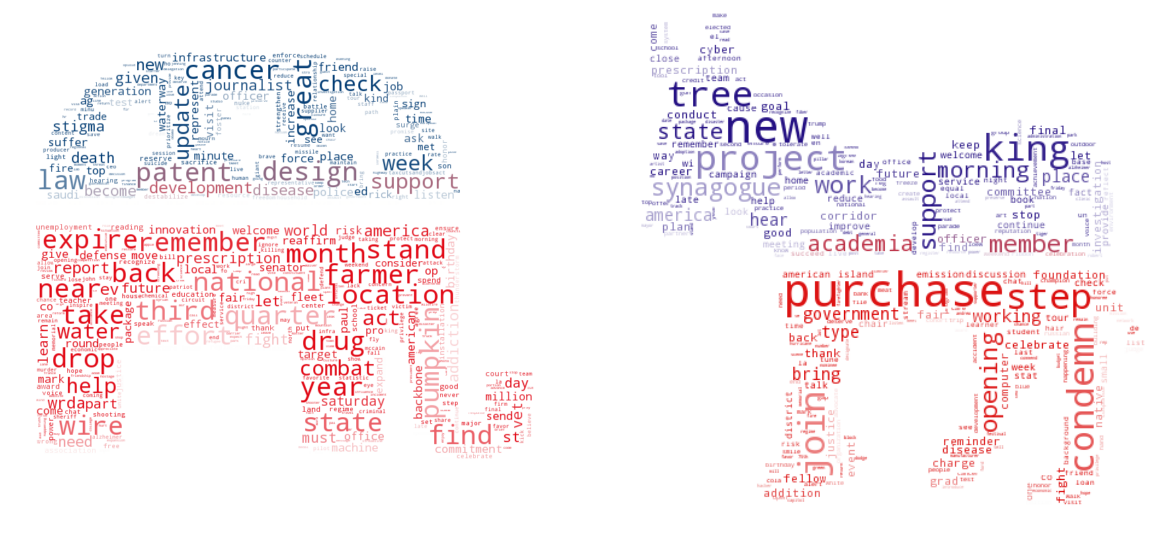

In [103]:
# generate long string for the purpose of word cloud
dem_text = ' '.join([w for w in Dem_df['word']])
rep_text = ' '.join([w for w in Rep_df['word']])    

# get the dictionary with pictures for backgrond of the word cloud
data_path = '/content/gdrive/My Drive/data'

# read the mask / color image taken from
# http://jirkavinse.deviantart.com/art/quot-Real-Life-quot-Alice-282261010
rep_coloring = np.array(Image.open(os.path.join(data_path, "pic/Rep_logo.jpg")))
dem_coloring = np.array(Image.open(os.path.join(data_path, "pic/Dem_logo.jpg")))
stopwords = set(STOPWORDS)

wc_rep = WordCloud(background_color="white", max_words=500, mask=rep_coloring,
               stopwords=stopwords, max_font_size=40, random_state=42)
wc_dem = WordCloud(background_color="white", max_words=500, mask=dem_coloring,
               stopwords=stopwords, max_font_size=40, random_state=42)


# generate word cloud
wc_rep.generate(rep_text)
wc_dem.generate(dem_text)

# create coloring from image
image_colors_rep = ImageColorGenerator(rep_coloring)
image_colors_dem = ImageColorGenerator(dem_coloring)

fig, axes = plt.subplots(1,2,figsize=(20,20))
# recolor wordcloud and show
# we could also give color_func=image_colors directly in the constructor
axes[0].imshow(wc_rep.recolor(color_func=image_colors_rep), interpolation="bilinear")
axes[1].imshow(wc_dem.recolor(color_func=image_colors_dem), interpolation="bilinear")


for ax in axes:
    ax.set_axis_off()
plt.show()

**WordCloud 1 and WordCloud 2** - Wordclouds representing top 500 words across all tweets for Republicans (left) and Democrats (Right)

* Are these topics less "boring" than the wikipedia topics from a few weeks ago? Why? Comment on the results.

**Answer:** Overall the words displyed on the twitter wordclouds for each party are a better representation of their values and interests . The wikipedia clouds were populated by expression such as "united states", "representative" "commite" "republican", "democrat", "state" ... and such that simply show a relation to politics in a general sense.

# Part 3 - Sentiment analysis# 
Download the LabMT wordlist. It's available as supplementary material from Temporal Patterns of Happiness and Information in a Global Social Network: Hedonometrics and Twitter (Data Set S1). 
- Describe briefly how the list was generated.

**Answer:** 

The wordlist is a distinct collection of the most frequent occurencens of words from collection of twitter, google books, music lyric and NewYorkTimes data.

After the collection of the words, individual people at Amazon's Mechanical Turk rated subset of 50 words on the list until every word got rated 50 times.
Based on their scores on a nine point integer scale the happiness score was getting calculated for every word.

So it has to be take into account that use of the data is based on a human evaluation.

In [0]:
#The downloading part of 'Data Set S1' is not included in this notebook
#Get the wordlist as a pandas Dataframe
wordList = pd.read_csv('/content/gdrive/My Drive/data/Data_Set_S1.csv')

In [0]:
#return the happiness average from the wordlist
def getHappinessAvg(word):
    return pd.to_numeric(wordList.loc[wordList['word']==word.lower()]['happiness_average']).values[0]
#Calculate the sentiment value for a give list of tokens (tweet)
#return the sentiment value as a float
#if len(tokenlist)==0 it returns a none type
def calcSentiment(tokenlist):
    # first we get rid of words that are not being evaluated, because of their lack in the wordlist
    tokenlist = [w.lower() for w in tokenlist if any(wordList['word'].isin([w]))]
    # socondly we count how many and how many times different words were used.
    fdist = nltk.FreqDist(tokenlist)
    # if there is no words to evaluate then the tweet is discart
    if len(tokenlist)==0:
        return None
    else:
        # here we count total score and divide it by number of the words that took part in evaluation
        return sum([getHappinessAvg(w)*occ for w,occ in fdist.items()])/sum([occ for w,occ in fdist.items()])


- Create two lists: one including the tokenized tweets written by democratic members, and the other including the tokenized tweets written by republican members. Calculate the sentiment of each tweet and plot the distribution of tweet sentiment for each of the two lists.

In [0]:
#This function tokenize a string and is extracting only the words
#returns a list of the words
def tokenizeTweet(tweet):
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(tweet)
    return tokens
#extract the rawTweet without the twitter handle and punctuation
#return the raw text of the tweet
def getRawTweets(file):
    exp='(.*)\n?'
    raw_tweets = re.findall(exp,file)
    raw_tweets = [tweet.split('http')[0] for tweet in raw_tweets]
    
    return raw_tweets



In [0]:
rep_tweets = []
dem_tweets = []
for file_path in file_paths:
    #get twitter handle
    key = file_path.rsplit('/', 1)[1]
    #open all tweets
    f = io.open(file_path,'r',encoding='utf-8').read()
    #get the raw tweet without the twitter handle as a list for each file
    raw_tweets = getRawTweets(f)
    if house_members_df.loc[house_members_df['tw_name'] == key, 'Party'].item() == "Republican":
        rep_tweets+=raw_tweets
    else:
        dem_tweets+=raw_tweets
#This function sets a list of tokens to lower case       
def setTokensToLowerCase(tweet):
    return [string.lower() for string in tweet]
 

- Calculate the sentiment of each tweet

In [0]:
rep_tweets_sep_tokens = [tokenizeTweet(tweet) for tweet in rep_tweets]
dem_tweets_sep_tokens = [tokenizeTweet(tweet) for tweet in dem_tweets]
#set to lower case
rep_tweets_sep_tokens_lower = [setTokensToLowerCase(sep_tweet) for sep_tweet in rep_tweets_sep_tokens]
dem_tweets_sep_tokens_lower = [setTokensToLowerCase(sep_tweet) for sep_tweet in dem_tweets_sep_tokens]

In [ ]:
rep_sentiment=[]
dem_sentiment=[]

for tweet in rep_tweets_sep_tokens_lower:
    rep_sentiment+=[calcSentiment(tweet)]

for tweet in dem_tweets_sep_tokens_lower:
    dem_sentiment+=[calcSentiment(tweet)]


- Plot the distribution of tweet sentiment for each of the two lists.

In [0]:
#get all the sentiment values without the none types
#They are none type for tweets which consist only of words, that are not includes in the wordlist from
rep_sentiment_clean = [sent for sent in rep_sentiment if sent is not None]
dem_sentiment_clean = [sent for sent in dem_sentiment if sent is not None]

# count sentiments 
rep_count= collections.Counter(rep_sentiment_clean)
rep_sent, rep_count= zip(*rep_count.items())
dem_count= collections.Counter(dem_sentiment_clean)
dem_sent, dem_count= zip(*dem_count.items())

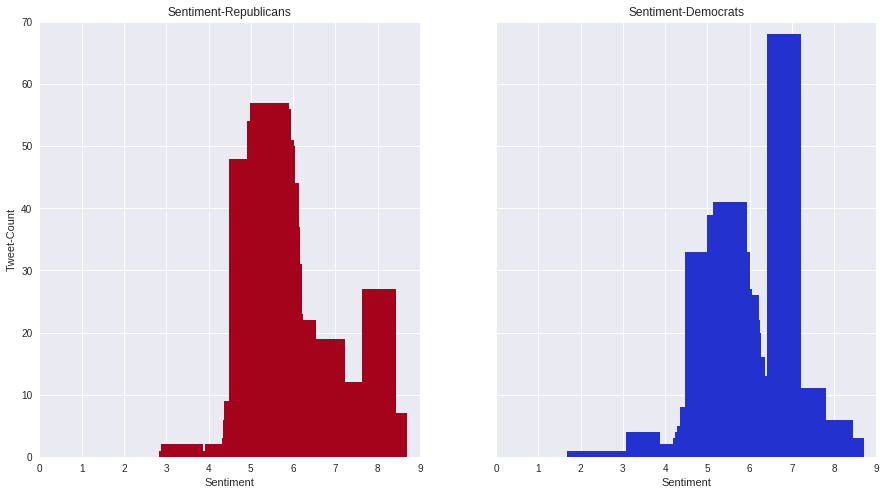

In [140]:
#Creating a graph for the sentiment distribution
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.bar(rep_sent, rep_count, width=0.80, color='#a5031b',linewidth=0.00000001)
ax1.set_title("Sentiment-Republicans")
ax1.set_ylabel("Tweet-Count")
ax1.set_xlabel("Total sentiment score per evaluated tweet word count")
ax1.set_xlim(0.0,9.0)
ax1.set_ylim(0.0,70.0)


ax2.bar(dem_sent, dem_count, width=0.80, color='#2331ce',linewidth=0.05)
ax2.set_title("Sentiment-Democrats")
ax2.set_xlabel("Sentiment")
ax2.set_xlim(0.0,9.0)
ax2.set_ylim(0.0,70.0)
f.set_size_inches(15,8)
plt.show()

**Figure 10 and Figure 11**- Sentiment Histogram for Republicans and Democrats. Horizontal axis responds to a tweet total sentiment score which is then normalized by division per number of evaluated words in that tweet.  Vertical axis simply responds to the tweet count.


* Are there significant differences between the two? Which party post more positive tweets?



**Answer:**
As you can see in Figure 10 and 11 the republicans tend to have more negative words in their tweets than the democrats. The republicans have the highest peak of of tweet sentiment between the values 4 and 6 hereas the democrats have their peak between 6.5 and 7.5. 


To sum up, the democrats post tweets which are more postive that the ones from republicans, but this assumption depend on how you define a negative and a positive tweet.
In the next part you will see also the number of negative and positve tweets based on the distance ($\pm2\sigma$).

- Compute the average m and standard deviation σ
 of the tweets sentiment (considering tweets by both republican and democrats).

In [69]:
rep_df_sentiment = pd.DataFrame({'sentiment':rep_sentiment_clean})
dem_df_sentiment = pd.DataFrame({'sentiment':dem_sentiment_clean})
m_rep=rep_df_sentiment['sentiment'].mean()
m_dem=dem_df_sentiment['sentiment'].mean()
sigma_rep= rep_df_sentiment['sentiment'].std()
sigma_dem= dem_df_sentiment['sentiment'].std()

print(m_rep,'+-',sigma_rep)
print(m_dem,'+-',sigma_dem)

5.517349493849213 +- 0.31907785939238936
5.449043196352246 +- 0.32327034131944415


* Now consider only tweets with sentiment lower than m-2$\sigma$. We will refer to them as negative tweets. Build a list containing the negative tweets written by democrats, and one for republicans. Compute the TF-IDF for these two lists (use the same pre-processing steps in Exercise 5). Create a word-cloud for each of them. 

In [0]:
rep_negative_tweets = pd.DataFrame(columns=['tweet','sentiment'])
for i,sentiment in enumerate(rep_sentiment):
    if sentiment is not None and sentiment<(m_rep-2*sigma_rep):
        tweet = rep_tweets[i]
        data={'tweet':[tweet],'sentiment':[sentiment]}
        appendFrame=pd.DataFrame(data)
        rep_negative_tweets=rep_negative_tweets.append(appendFrame,ignore_index=True)
        
dem_negative_tweets = pd.DataFrame(columns=['tweet','sentiment'])
for i,sentiment in enumerate(dem_sentiment):
    if sentiment is not None and sentiment<(m_dem-2*sigma_dem):
        tweet = dem_tweets[i]
        data={'tweet':[tweet],'sentiment':[sentiment]}
        appendFrame=pd.DataFrame(data)
        dem_negative_tweets=dem_negative_tweets.append(appendFrame,ignore_index=True)
   

In [0]:

#function to get all the word tokens from a string without any stopwords,html tags, numbers
#return the tokens as a list of lower case words
def getCleanTokens(listOfStrings):
    tokens=[]
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    for tweet in listOfStrings['tweet']:
        tokens +=tokenizer.tokenize(tweet)
    #exclude Stopwords
    tokens = [w for w in tokens if w.lower() not in stop_words]
    #exluce HTML Tag amp or retweet handle rt
    tokens = [w for w in tokens if w !='amp'and w.lower()!='rt']
    #exclude numbers
    tokens = [w for w in tokens if not w.isdigit()]
    #set everything to lower case
    tokens = [w.lower() for w in tokens]
    return tokens



In [0]:
#getting a clean list of tokens for each party
rep_negative_tweets_clean = getCleanTokens(rep_negative_tweets)
dem_negative_tweets_clean = getCleanTokens(dem_negative_tweets)

In [0]:
#calculate the tdidf values for the tokens
(rep_negative_tweets_TDIDF,dem_negative_tweets_TDIDF) = calculateTFIDF(rep_negative_tweets_clean,dem_negative_tweets_clean)

In [132]:
#top 10 negative words regarding to their TD-IDF value
print(color.BOLD + '                Republicans                                      Democrats'+ color.END)
display_side_by_side(rep_negative_tweets_TDIDF.sort_values(by=['TF-IDF'],ascending=False).head(10),dem_negative_tweets_TDIDF.sort_values(by=['TF-IDF'],ascending=False).head(10))

               Republicans                              Democrats


,word,occurences,TF-IDF
40,unemployment,104,0.008123
45,lowest,51,0.003983
186,rate,43,0.003358
212,economy,27,0.002109
1104,betteroffnow,24,0.001874
1615,rohrabacher,20,0.001562
158,stevescalise,19,0.001484
256,level,17,0.001328
862,jobless,17,0.001328
751,tragically,14,0.001093


**Table 5 and Table 6** - Top 10 Republicans (left) and Democrats (right) negative tokens sorted with regards to the TF-IDF values.

In [0]:
def createWordCloudPair(rep_tokens,dem_tokens):
  data_path = '/content/gdrive/My Drive/data'

  # Read the whole text.
  dem_text = ' '.join([w for w in dem_tokens])
  rep_text = ' '.join([w for w in rep_tokens])
  # read the mask / color image taken from
  rep_coloring = np.array(Image.open(os.path.join(data_path, "pic/Rep_logo.jpg")))
  dem_coloring = np.array(Image.open(os.path.join(data_path, "pic/Dem_logo.jpg")))
  stopwords = set(STOPWORDS)

  wc_rep = WordCloud(background_color="white", max_words=300, mask=rep_coloring,
               stopwords=stopwords, max_font_size=40, random_state=42)
  wc_dem = WordCloud(background_color="white", max_words=300, mask=dem_coloring,
               stopwords=stopwords, max_font_size=40, random_state=42)


  # generate word cloud
  wc_rep.generate(rep_text)
  wc_dem.generate(dem_text)

  # create coloring from image
  image_colors_rep = ImageColorGenerator(rep_coloring)
  image_colors_dem = ImageColorGenerator(dem_coloring)

  fig, axes = plt.subplots(1,2,figsize=(20,20))
  # recolor wordcloud and show
  # we could also give color_func=image_colors directly in the constructor
  axes[0].imshow(wc_rep.recolor(color_func=image_colors_rep), interpolation="bilinear")
  axes[1].imshow(wc_dem.recolor(color_func=image_colors_dem), interpolation="bilinear")


  for ax in axes:
    ax.set_axis_off()
  plt.show()

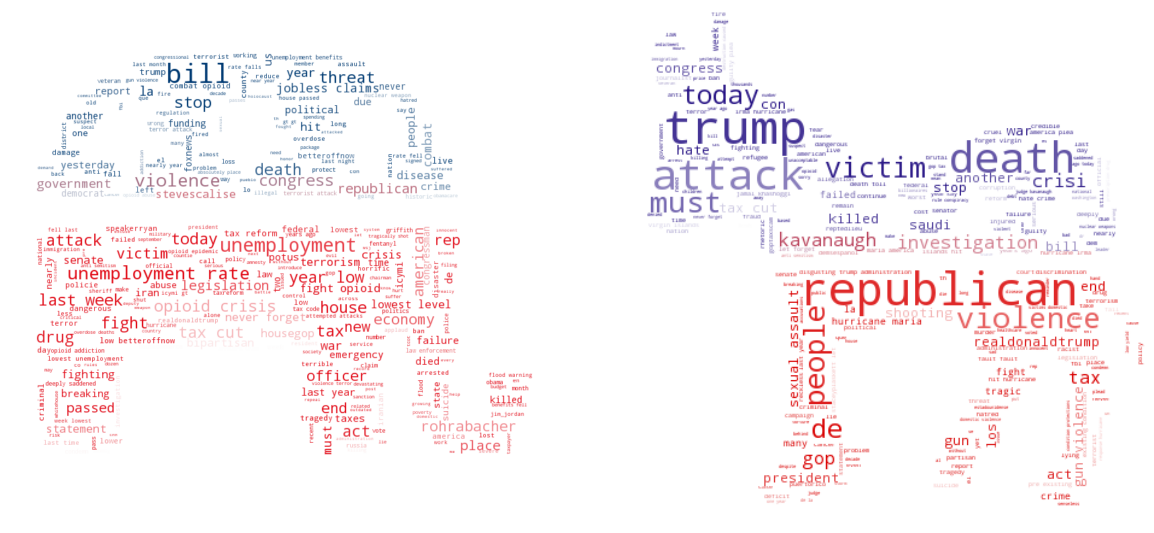

In [51]:
createWordCloudPair(rep_negative_tweets_clean,dem_negative_tweets_clean)

**Wordcloud 3 and Workcloud 4**-  Wordclouds of Negative Tweets for Republicans and Democrats
- Comment on the differences between the negative contents posted by republicans and democrats.

**Answer:** Based on both wordclouds  it seems the negative tweets from republicans are  more centered around terms related to US economy and living conditions such as "bill", "unemployment" and "tax". Democrats negative tweets are filled with expressions with bigger "shock value" such as "death", "victim", "attack", ""violence","killed" and of course trump realdonaldtrump (which is his twitter handle) and president as they most likely have a lot of negative to say about President Trump and the opposing party. This makes sense also when considering that the republicans are the ones currently in power so their negative tweets are more adressing actual economical and social factors.

- Repeat the point above, but considering positive tweets instead (e.g. with sentiment larger than m+2$\sigma$). Comment on your results.

In [0]:
rep_positive_tweets = pd.DataFrame(columns=['tweet','sentiment'])
for i,sentiment in enumerate(rep_sentiment):
    if sentiment is not None and sentiment>(m_rep+2*sigma_rep):
        tweet = rep_tweets[i]
        data={'tweet':[tweet],'sentiment':[sentiment]}
        appendFrame=pd.DataFrame(data)
        rep_positive_tweets=rep_positive_tweets.append(appendFrame,ignore_index=True)
        
dem_positive_tweets = pd.DataFrame(columns=['tweet','sentiment'])
for i,sentiment in enumerate(dem_sentiment):
    if sentiment is not None and sentiment>(m_dem+2*sigma_dem):
        tweet = dem_tweets[i]
        data={'tweet':[tweet],'sentiment':[sentiment]}
        appendFrame=pd.DataFrame(data)
        dem_positive_tweets=dem_positive_tweets.append(appendFrame,ignore_index=True)
   

In [0]:
#getting a clean list of tokens for each party
rep_positive_tweets_clean = getCleanTokens(rep_positive_tweets)
dem_positive_tweets_clean = getCleanTokens(dem_positive_tweets)

In [0]:
#calculate the tdidf values for the tokens
(rep_positive_tweets_TDIDF,dem_positive_tweets_TDIDF) = calculateTFIDF(rep_positive_tweets_clean,dem_positive_tweets_clean)

In [138]:
#Printing the top 10 positive words regarding their TD-IDF values
print(color.BOLD + '               Republicans                                 Democrats'+ color.END)
display_side_by_side(rep_positive_tweets_TDIDF.sort_values(by=['TF-IDF'],ascending=False).head(10),dem_positive_tweets_TDIDF.sort_values(by=['TF-IDF'],ascending=False).head(10))

               Republicans                                 Democrats


,word,occurences,TF-IDF
180,potus,18,0.001838
127,wife,16,0.001634
1250,al03,15,0.001532
751,betteroffnow,11,0.001123
225,mom,10,0.001021
47,fellow,10,0.001021
22,speakerryan,9,0.000919
964,flagday,8,0.000817
262,vp,8,0.000817
752,taxcutsandjobsact,8,0.000817


**Table 7 and Table 8** - Top 10 Republicans (left) and Democrats (right) positive tokens sorted with regards to the TF-IDF values.

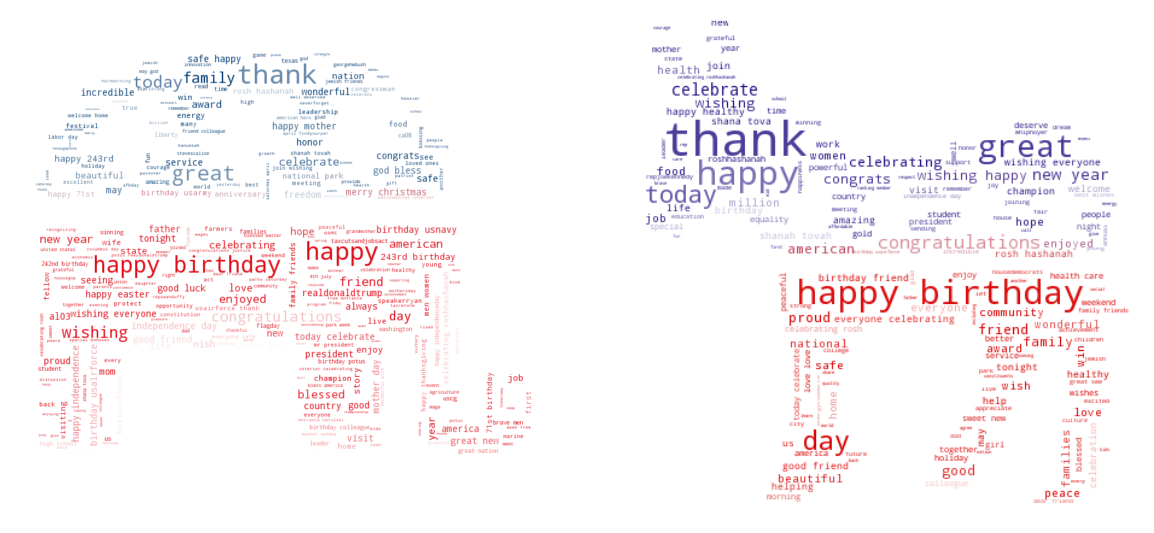

In [79]:
createWordCloudPair(rep_positive_tweets_clean,dem_positive_tweets_clean)

**Wordcloud 5 and Workcloud 6** - Wordclouds of positive tweets for Republicans and Democrats
- Comment on the results

**Answer:** Upon analyzing the wordclouds for positive tweets for both parties we observe that there is not much difference between the words used by Democrats (Wordcloud 6) and Republicans (Wordcloud 5) in their positive tweets. They both adress things such as birthdays, "happy", "thank", "great" and other general words with a positive connotation. 

We could not spot president anywhere in the democrats wordcloud while the republicans have it present for obvious reasons.
